# Classifying Heart Disease

In this guided project I will be looking at a real-life dataset: the [Heart Disease Data Set](https://archive.ics.uci.edu/dataset/45/heart+disease) from the UCI Machine Learning Repository. This dataset comes from the famous Cleveland Clinic Foundation, which recorded information on various patient characteristics, including age and chest pain, to try to classify the presence of heart disease in an individual.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

heart = pd.read_csv("data/heart_disease.csv")

## Exploring the dataset

First I will explore the dataset to determine if any adjustments need to be made and check the distribution of the predictors

In [2]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    int64  
 3   cp          303 non-null    int64  
 4   trestbps    303 non-null    int64  
 5   chol        303 non-null    int64  
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     303 non-null    int64  
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    object 
 13  thal        303 non-null    object 
 14  present     303 non-null    int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 35.6+ KB


The columns in the dataset are defined by the source as:  
- `age` Age in years
- `sex` Categorical
- `cp` Categorical
- `trestbps` Integer, resting blood pressure (on admission to the hospital)
- `chol` Integer, serum cholestoral 
- `fbs` Categorical, fasting blood sugar > 120 mg/dl
- `restecg` Categorical, resting electrocardiographic results. `0` = normal, `1` = ST-T wave abnormality, `2` = showing probable or definite left ventricular hypertrophy
- `thalach` Integer, maximum heart rate achieved
- `exang` Categorical, exercise induced angina
- `oldpeak` Integer, ST depression induced by exercise relative to rest
- `slope` Categorical
- `ca` Integer, number of major vessels (0-3) colored by flourosopy
- `thal` Categorical
- `present` Target, diagnosis of heart disease

### Cleaning

There are some errors in the `ca` and `thal` columns I will look at next

In [3]:
heart['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

There are 4 `?` in `ca`. I will replace these with the modal value `0`

In [4]:
heart['ca'] = heart['ca'].replace({"?":"0"})
heart['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
0        4
Name: ca, dtype: int64

In [5]:
heart['thal'].value_counts()

3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64

There are 2 `?` in the `thal` column. I will replace these with  the modal value `3`

In [6]:
heart['thal'] = heart['thal'].replace({"?":"3"})
heart['thal'].value_counts()

3.0    166
7.0    117
6.0     18
3        2
Name: thal, dtype: int64

In [7]:
# convert to float from object
heart['ca'] = heart['ca'].astype(float)
heart['thal'] = heart['thal'].astype(float)

### Exploration

array([[<Axes: title={'center': 'present'}>]], dtype=object)

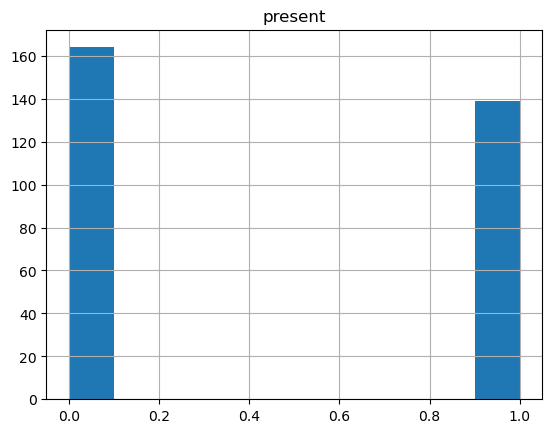

In [8]:
heart.hist("present")

Out of the 303 observations, there is a fairly even split in our target variable. With around 140 observations with heart disease and just over 160 without.

In [9]:
heart.groupby("present").agg(
    {
        "age": "mean",
        "sex": "mean",
        "cp": "mean",
        "trestbps": "mean",
        "chol": "mean",
        "fbs": "mean",
        "restecg": "mean",
        "thalach": "mean",
        "exang": "mean",
        "oldpeak": "mean",
        "slope": "mean",
        "ca" : "mean",
        "thal" : "mean"
    }
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
present,,,,,,,,,,,,,
0,52.585366,0.560976,2.792683,129.250000,242.640244,0.140244,0.835366,158.378049,0.140244,0.586585,1.408537,0.268293,3.792683
1,56.625899,0.820144,3.589928,134.568345,251.474820,0.158273,1.172662,139.258993,0.546763,1.574101,1.827338,1.129496,5.820144


The above shows the predictors stratified by the target variable. The predictors with the largest differences should be selected for training in the model. Looking at the above, good candiates are:  
- `age`
- `restecg`
- `thalach`
- `ca`

## Dividing the data

I will now split the dataset into train and test subsets. This is so there is some unseen data to test the model on after is has been trained.  
I will allocate **20%** to the test set. I will set a random seed to make the results reproducable.

In [10]:
from sklearn.model_selection import train_test_split

X = heart[["age","restecg","thalach","ca"]]
y = heart["present"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=303)

In [11]:
y_train.value_counts()

0    131
1    111
Name: present, dtype: int64

In [12]:
y_test.value_counts()

0    33
1    28
Name: present, dtype: int64

The dataset has been split. The train and test subsets contain a good amount of both cases and non-cases.

## Building the Model

I will now build the model using LogisticRegression.  
I will assess the model by:
- accuracy: how well the model predicts an case overall
- sensitivity: how well were the actual cases predicted
- specificity: how well were the actual non-cases predicted

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_train)
accuracy = model.score(X_train, y_train)

tp = sum((y_train == 1) & (predictions == 1))
fn = sum((y_train == 1) & (predictions == 0))
tn = sum((y_train == 0) & (predictions == 0))
fp = sum((y_train == 0) & (predictions == 1))

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print('accuracy:',accuracy)
print('sensitivity:',sensitivity)
print('specificity:',specificity)

accuracy: 0.7603305785123967
sensitivity: 0.6846846846846847
specificity: 0.8244274809160306


Overall the model's predictions were correct 76% of the time.  

However it was better at predicting the non-cases.  
The specificty shows that the non-cases were predicted correctly 82% of the time.  
Whereas the sensitivity shows the cases were predicted correctly only 68% of the time.

## Interpreting the Model Coefficients

The model coefficients can describe how each predictor affects the outcome

In [14]:
model.coef_

array([[-0.00137217,  0.31965891, -0.03471048,  1.10864487]])

The above coefficients shopw the log-odds ration for a unit increase of each predictor.

Next I will examine the odds scales.

In [15]:
age_odds = np.exp(model.coef_[0,0])
restecg_odds = np.exp(model.coef_[0,1])
thalach_odds = np.exp(model.coef_[0,2])
ca_odds = np.exp(model.coef_[0,3])

print('age odds ratio:',age_odds)
print('restecg odds ratio:',restecg_odds)
print('thalach odds ratio:',thalach_odds)
print('ca odds ratio:',ca_odds)

age odds ratio: 0.9986287725208344
restecg odds ratio: 1.3766581236722981
thalach odds ratio: 0.9658850216561469
ca odds ratio: 3.0302492171842887


The above odds ratios indicate that higher ages and higher maximum heart rates (`thalach`) are associated with a lower chance of heart disease. The odds are still relatively low, with values that are close to 1.   
Also more resting ecg abnormality (`restecg`) and higher number of major vessels coloured by fluroscopy (`ca`) are associated with a higher chance of heart disease.   
The odds ratios indicate moderate (37%) increase with `restecg` and a high (203%) increase with `ca`.

## Final Evaluation

Now I will conduct a final evaluation uusing the test set.

In [16]:
test_predictions = model.predict(X_test)
test_accuracy = model.score(X_test, y_test)

test_tp = sum((y_test == 1) & (test_predictions == 1))
test_fn = sum((y_test == 1) & (test_predictions == 0))
test_tn = sum((y_test == 0) & (test_predictions == 0))
test_fp = sum((y_test == 0) & (test_predictions == 1))

test_sensitivity = test_tp / (test_tp + test_fn)
test_specificity = test_tn / (test_tn + test_fp)

print('accuracy:',test_accuracy)
print('sensitivity:',test_sensitivity)
print('specificity:',test_specificity)

accuracy: 0.7213114754098361
sensitivity: 0.5714285714285714
specificity: 0.8484848484848485


The overall accuracy has dropped slightly from the training evaluation to 72%.

However the difference between the sensitivity and the specficity has increased.  
A sensitivity of 57% indicates the model performs quite poorly on positive cases.  
A specificty of 84% indicates the model perform quite well on negative cases.